In [1]:
import numpy as np 
import matplotlib.pyplot as plt

In [2]:
from numba import njit
@njit
def central_difference_gradient(map_3d, dx=1, dy=1, dz=1):
    grad_x = np.zeros_like(map_3d).astype(np.float32)
    grad_y = np.zeros_like(map_3d).astype(np.float32)
    grad_z = np.zeros_like(map_3d).astype(np.float32)
    
    # Calculate gradient using central difference
    grad_x[1:-1,:,:] = np.abs((map_3d[2:,:,:] - map_3d[:-2,:,:]) / (2 * dx))
    grad_y[:,1:-1,:] = np.abs((map_3d[:,2:,:] - map_3d[:,:-2,:]) / (2 * dy))
    grad_z[:,:,1:-1] = np.abs((map_3d[:,:,2:] - map_3d[:,:,:-2]) / (2 * dz))
    
    return grad_x, grad_y, grad_z

@njit
def get_gradient_map(map_2d):
    grad_x, grad_y,grad_z  = central_difference_gradient(map_2d)
    grad_magnitude = np.sqrt(grad_x**2 + grad_y**2 + grad_z**2)
    grad_direction = None
    return grad_x, grad_y , grad_z, grad_magnitude, grad_direction

In [10]:
boundary = np.fromfile("../build/boundary.int8", dtype=np.int8).reshape(256,384,384)

0.004060348
-0.004060348
(array([ 3462839,  3462840,  3462841, ..., 37597655, 37597656, 37597657]),)


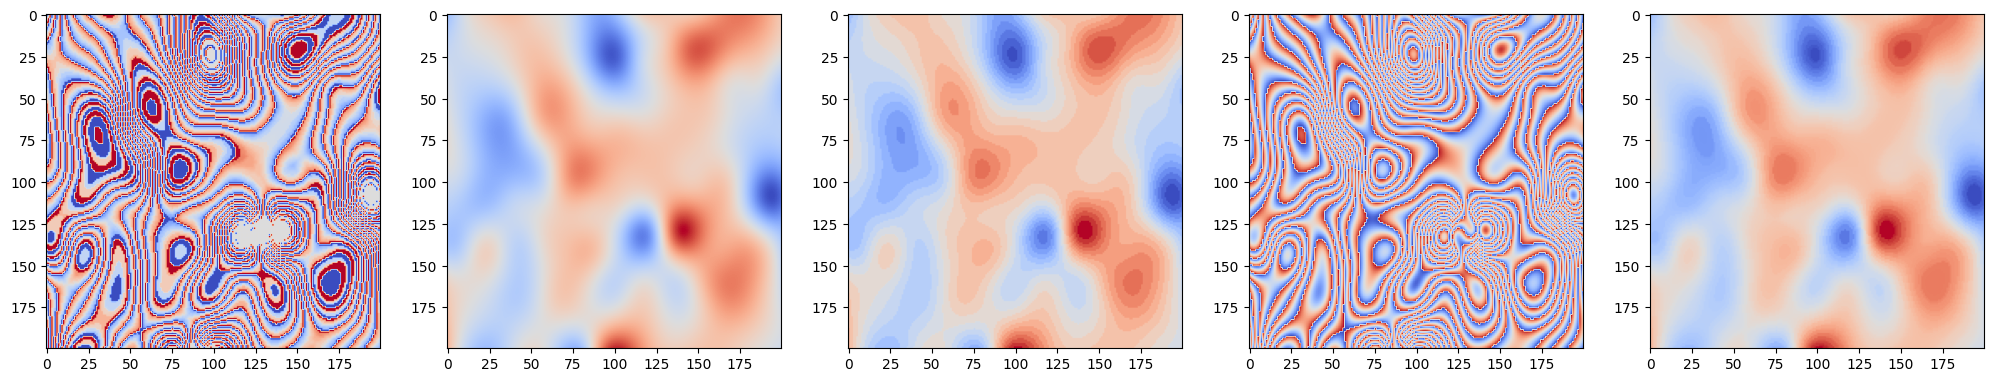

In [11]:
comp = np.fromfile("../build/compensation_map_miranda_vx2.f32",dtype=np.float32).reshape(256,384,384)
odata = np.fromfile("/project/xli281_uksr/pjiao/data/miranda/velocityx.f32",dtype=np.float32).reshape(256,384,384)
ddata = np.fromfile("/scratch/pji228/useful/direct_quantize/miranda/velocityx.f320.001.out",dtype=np.float32).reshape(256,384,384) 
qindex = np.fromfile("/scratch/pji228/useful/direct_quantize/miranda/velocityx.f320.001.quant.i32",dtype=np.int32).reshape(256,384,384) -2**15 
error = odata - ddata
compensated_data = ddata + comp 
figs, axs = plt.subplots(1,5,figsize=(25,5))
x_slice = 81
x1 = 100
x2 = 300
y1 = 100
y2 = 300
axs[0].imshow(comp[x_slice,x1:x2,y1:y2], cmap='coolwarm', interpolation=None)
axs[1].imshow(odata[x_slice,x1:x2,y1:y2], cmap='coolwarm', interpolation=None)
axs[2].imshow(ddata[x_slice,x1:x2,y1:y2], cmap='coolwarm', interpolation=None)
axs[3].imshow(error[x_slice,x1:x2,y1:y2], cmap='coolwarm', interpolation=None)
axs[4].imshow(compensated_data[x_slice,x1:x2,y1:y2], cmap='coolwarm', interpolation=None)
print(comp.max())
print(comp.min())
print(np.where(comp.flatten() == comp.max()))

In [7]:
grad_x, grad_y , grad_z, grad_magnitude, grad_direction = get_gradient_map(qindex)

Text(0.5, 1.0, 'Recovered error')

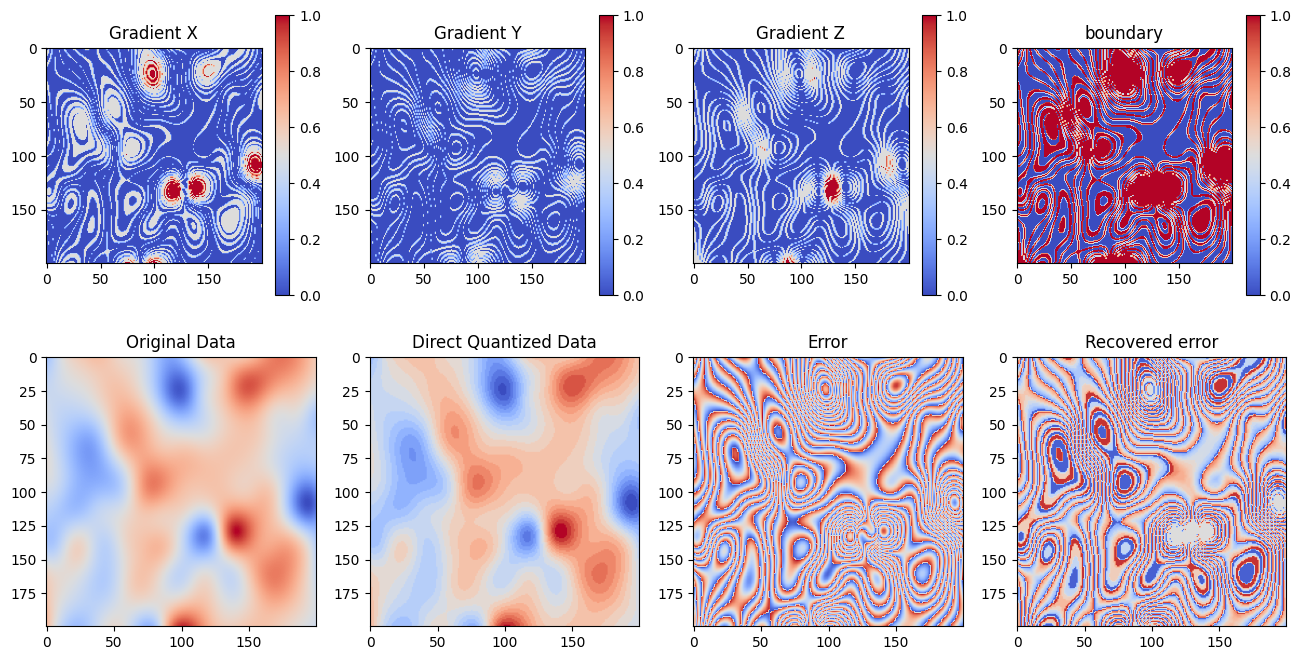

In [12]:
figs, axs = plt.subplots(2,4,figsize=(16,8))
im = axs[0,0].imshow(grad_x[x_slice,x1:x2,y1:y2], cmap='coolwarm', vmax=1, vmin=0)
axs[0,0].set_title("Gradient X")
plt.colorbar(im, ax=axs[0,0])   
im = axs[0,1].imshow(grad_y[x_slice,x1:x2,y1:y2], cmap='coolwarm', vmax=1, vmin=0)
axs[0,1].set_title("Gradient Y")
plt.colorbar(im, ax=axs[0,1])
im = axs[0,2].imshow(grad_z[x_slice,x1:x2,y1:y2], cmap='coolwarm', vmax=1, vmin=0)
axs[0,2].set_title("Gradient Z")
plt.colorbar(im, ax=axs[0,2])
# im = axs[0,3].imshow(grad_magnitude[x_slice,x1:x2,y1:y2], cmap='coolwarm', vmax=1, vmin=0)
# axs[0,3].set_title("Gradient Magnitude")
# plt.colorbar(im, ax=axs[0,3])

im = axs[0,3].imshow(boundary[x_slice,x1:x2,y1:y2], cmap='coolwarm', vmax=1, vmin=0)
axs[0,3].set_title("boundary")
plt.colorbar(im, ax=axs[0,3])


axs[1,0].imshow(odata[x_slice,x1:x2,y1:y2], cmap='coolwarm', )
axs[1,0].set_title("Original Data")
axs[1,1].imshow(ddata[x_slice,x1:x2,y1:y2], cmap='coolwarm', )
axs[1,1].set_title("Direct Quantized Data")
emax = np.max(np.abs(error))

axs[1,2].imshow(error[x_slice,x1:x2,y1:y2], cmap='coolwarm',vmax=emax, vmin=-emax)
axs[1,2].set_title("Error")
axs[1,3].imshow(comp[x_slice,x1:x2,y1:y2], cmap='coolwarm', vmax=emax, vmin=-emax)
axs[1,3].set_title("Recovered error")


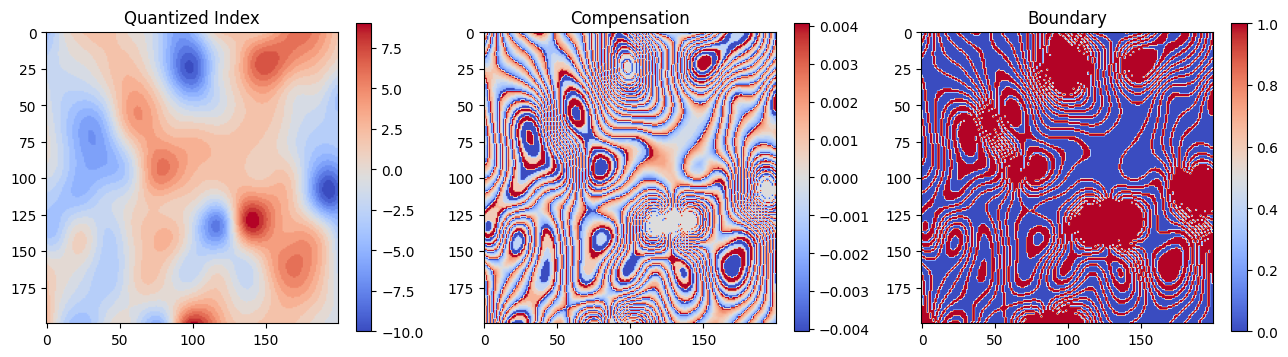

In [17]:
figs, axs = plt.subplots(1,3,figsize=(16,8)) 
im = axs[0].imshow(qindex[x_slice,x1:x2,y1:y2], cmap='coolwarm')
axs[0].set_title("Quantized Index")
plt.colorbar(im, ax=axs[0],shrink=0.5)  
im = axs[1].imshow(comp[x_slice,x1:x2,y1:y2], cmap='coolwarm')
axs[1].set_title("Compensation")
plt.colorbar(im, ax=axs[1],shrink=0.5)
im = axs[2].imshow(boundary[x_slice,x1:x2,y1:y2], cmap='coolwarm')
axs[2].set_title("Boundary")
plt.colorbar(im, ax=axs[2],shrink=0.5)

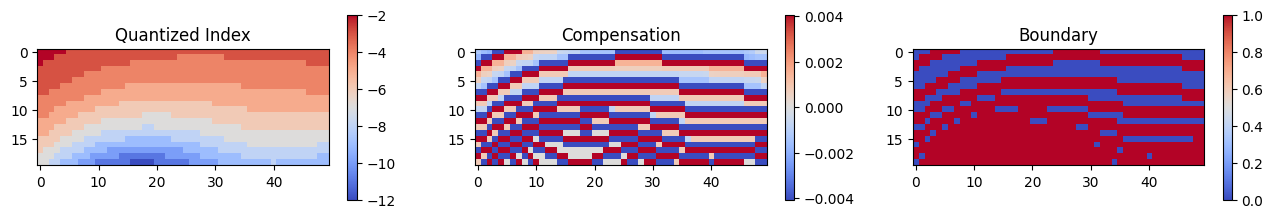

In [22]:
x_slice = 100+25 
y1 = 81-10
y2 = 81+10 
z1 = 100+50
z2 = 100+100 
figs, axs = plt.subplots(1,3,figsize=(16,8)) 
im = axs[0].imshow(qindex[y1:y2, z1:z2,x_slice], cmap='coolwarm')
axs[0].set_title("Quantized Index")
plt.colorbar(im, ax=axs[0],shrink=0.3)  
im = axs[1].imshow(comp[y1:y2, z1:z2,x_slice], cmap='coolwarm')
axs[1].set_title("Compensation")
plt.colorbar(im, ax=axs[1],shrink=0.3)
im = axs[2].imshow(boundary[y1:y2, z1:z2,x_slice], cmap='coolwarm')
axs[2].set_title("Boundary")
plt.colorbar(im, ax=axs[2],shrink=0.3)

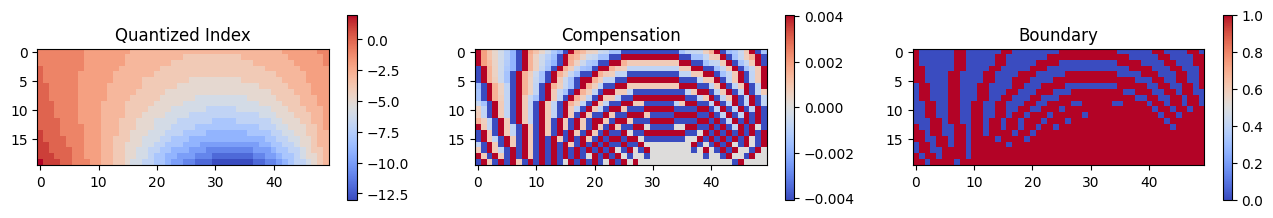

In [23]:
x_slice = 175 
y1 = 81-10
y2 = 81+10 
z1 = 100
z2 = 150 
figs, axs = plt.subplots(1,3,figsize=(16,8)) 
im = axs[0].imshow(qindex[y1:y2, x_slice, z1:z2], cmap='coolwarm')
axs[0].set_title("Quantized Index")
plt.colorbar(im, ax=axs[0],shrink=0.3)  
im = axs[1].imshow(comp[y1:y2, x_slice, z1:z2], cmap='coolwarm')
axs[1].set_title("Compensation")
plt.colorbar(im, ax=axs[1],shrink=0.3)
im = axs[2].imshow(boundary[y1:y2, x_slice, z1:z2], cmap='coolwarm')
axs[2].set_title("Boundary")
plt.colorbar(im, ax=axs[2],shrink=0.3)

0.004060348
-0.004060348
(array([ 3462839,  3462840,  3462841, ..., 37597655, 37597656, 37597657]),)


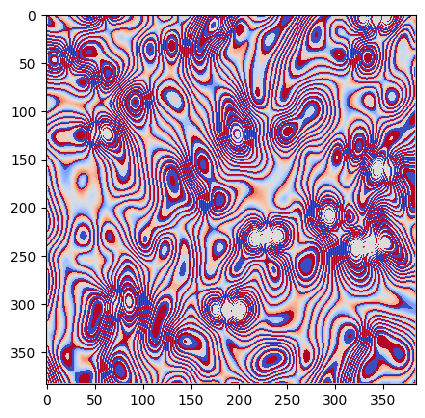

In [8]:
comp = np.fromfile("../build/compensation_map.f32",dtype=np.float32).reshape(256,384,384)
plt.imshow(comp[81], cmap='coolwarm', interpolation='nearest')
print(comp.max())
print(comp.min())
print(np.where(comp.flatten() == comp.max()))

0.004060348
-0.004060348
(array([ 3462839,  3462840,  3462841, ..., 37597655, 37597656, 37597657]),)


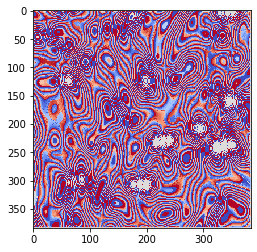

In [3]:
comp = np.fromfile("../build/compensation_map.f32",dtype=np.float32).reshape(256,384,384)
plt.imshow(comp[81], cmap='coolwarm', interpolation='nearest')
print(comp.max())
print(comp.min())
print(np.where(comp.flatten() == comp.max()))

0.3890205
-0.3890205
(array([ 45216709,  45216710,  45217060, ..., 295395691, 295396043,
       295396395]),)


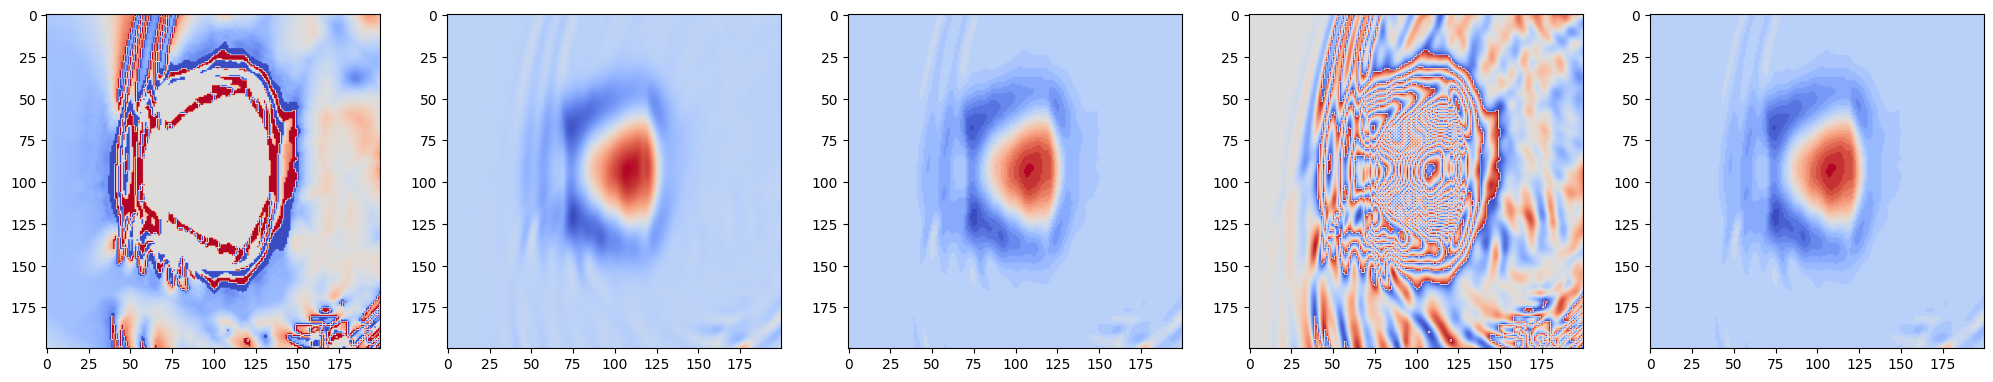

In [20]:
comp = np.fromfile("../build/compensation_map.f32",dtype=np.float32).reshape(1008,1008,352)
odata = np.fromfile("/project/xli281_uksr/pjiao/data/aramco_1008x1008x352/pressure_2000.f32.dat",dtype=np.float32).reshape(1008,1008,352)
ddata = np.fromfile("../build/pressure_2000.f32.dat.out",dtype=np.float32).reshape(1008,1008,352) 
qindex = np.fromfile("../build/pressure_2000.f32.dat.quant.i32",dtype=np.int32).reshape(1008,1008,352)-2**15
error = odata - ddata
compensated_data = ddata + comp 
figs, axs = plt.subplots(1,5,figsize=(25,5))
x_slice = 219
x1 = 400
x2 = 600
y1 = 0
y2 = 200
axs[0].imshow(comp[x_slice,x1:x2,y1:y2], cmap='coolwarm', interpolation=None)
axs[1].imshow(odata[x_slice,x1:x2,y1:y2], cmap='coolwarm', interpolation=None)
axs[2].imshow(ddata[x_slice,x1:x2,y1:y2], cmap='coolwarm', interpolation=None)
axs[3].imshow(error[x_slice,x1:x2,y1:y2], cmap='coolwarm', interpolation=None)
axs[4].imshow(qindex[x_slice,x1:x2,y1:y2], cmap='coolwarm', interpolation=None)
print(comp.max())
print(comp.min())
print(np.where(comp.flatten() == comp.max()))

In [17]:
from numba import njit
@njit
def central_difference_gradient(map_3d, dx=1, dy=1, dz=1):
    grad_x = np.zeros_like(map_3d).astype(np.float32)
    grad_y = np.zeros_like(map_3d).astype(np.float32)
    grad_z = np.zeros_like(map_3d).astype(np.float32)
    
    # Calculate gradient using central difference
    grad_x[1:-1,:,:] = np.abs((map_3d[2:,:,:] - map_3d[:-2,:,:]) / (2 * dx))
    grad_y[:,1:-1,:] = np.abs((map_3d[:,2:,:] - map_3d[:,:-2,:]) / (2 * dy))
    grad_z[:,:,1:-1] = np.abs((map_3d[:,:,2:] - map_3d[:,:,:-2]) / (2 * dz))
    
    return grad_x, grad_y, grad_z

@njit
def get_gradient_map(map_2d):
    grad_x, grad_y,grad_z  = central_difference_gradient(map_2d)
    grad_magnitude = np.sqrt(grad_x**2 + grad_y**2 + grad_z**2)
    grad_direction = None
    return grad_x, grad_y , grad_z, grad_magnitude, grad_direction

In [21]:
grad_x, grad_y , grad_z, grad_magnitude, grad_direction = get_gradient_map(qindex)

Text(0.5, 1.0, 'Recovered error')

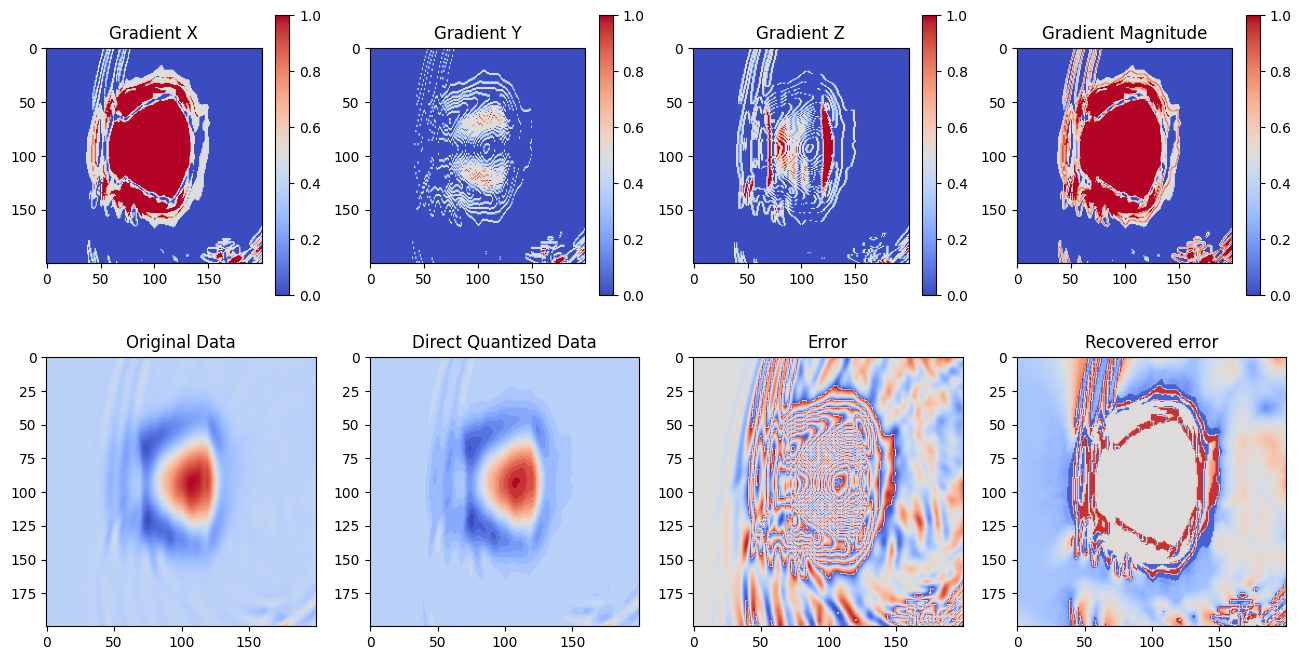

In [22]:
figs, axs = plt.subplots(2,4,figsize=(16,8))
im = axs[0,0].imshow(grad_x[x_slice,x1:x2,y1:y2], cmap='coolwarm', vmax=1, vmin=0)
axs[0,0].set_title("Gradient X")
plt.colorbar(im, ax=axs[0,0])   
im = axs[0,1].imshow(grad_y[x_slice,x1:x2,y1:y2], cmap='coolwarm', vmax=1, vmin=0)
axs[0,1].set_title("Gradient Y")
plt.colorbar(im, ax=axs[0,1])
im = axs[0,2].imshow(grad_z[x_slice,x1:x2,y1:y2], cmap='coolwarm', vmax=1, vmin=0)
axs[0,2].set_title("Gradient Z")
plt.colorbar(im, ax=axs[0,2])
im = axs[0,3].imshow(grad_magnitude[x_slice,x1:x2,y1:y2], cmap='coolwarm', vmax=1, vmin=0)
axs[0,3].set_title("Gradient Magnitude")
plt.colorbar(im, ax=axs[0,3])
axs[1,0].imshow(odata[x_slice,x1:x2,y1:y2], cmap='coolwarm', )
axs[1,0].set_title("Original Data")
axs[1,1].imshow(ddata[x_slice,x1:x2,y1:y2], cmap='coolwarm', )
axs[1,1].set_title("Direct Quantized Data")
emax = np.max(np.abs(error))

axs[1,2].imshow(error[x_slice,x1:x2,y1:y2], cmap='coolwarm',vmax=emax, vmin=-emax)
axs[1,2].set_title("Error")
axs[1,3].imshow(comp[x_slice,x1:x2,y1:y2], cmap='coolwarm', vmax=emax, vmin=-emax)
axs[1,3].set_title("Recovered error")


In [4]:
comp = np.fromfile("../build/compensation_map.f32",dtype=np.float32).reshape(256)
plt.imshow(comp[221], cmap='coolwarm', interpolation='nearest')
print(comp.max())
print(comp.min())
print(np.where(comp.flatten() == comp.max()))

ValueError: cannot reshape array of size 357654528 into shape (256,)

In [ ]:
comp = np.fromfile("../build/compensation_map.f32",dtype=np.float32).reshape()
plt.imshow(comp[221], cmap='coolwarm', interpolation='nearest')
print(comp.max())
print(comp.min())
print(np.where(comp.flatten() == comp.max()))

In [4]:
distance_array = np.fromfile("distance_array.f64",dtype=np.float64).reshape(200, 134) 
plt.imshow(distance_array, cmap='coolwarm', interpolation='nearest')

FileNotFoundError: [Errno 2] No such file or directory: 'distance_array.f64'

In [5]:
comp = np.fromfile("compensation_map.f32",dtype=np.float32).reshape(256,384,384)
plt.imshow(comp[81], cmap='coolwarm', interpolation='nearest')
print(comp.max())
print(comp.min())
print(np.where(comp.flatten() == comp.max()))

FileNotFoundError: [Errno 2] No such file or directory: 'compensation_map.f32'